# Código de la simulación

## Métodos y estructuras auxiliares


### Importación de librerías de utilidad

In [56]:
import numpy as np
import heapq as heap
import matplotlib.pyplot as plt
from scipy import stats

### Métodos auxiliares

In [57]:

# Crear una central telefónica con n líneas
def make_central(n):
   return [False for i in range(n)]


# Calcular el dinero destinado a salarios en un día
def calculate_salaries(line_count, salary_per_hour, simulation_hours):
    return line_count*salary_per_hour*simulation_hours

# Condición de parada de la simulacion
def stop_case(result, umbral):
    if len(result) > 1:
        dvs = np.std(result, axis=0)
        stop=True
        for i in range(len(dvs)):
           stop &= ( 2*1.96*dvs[i]/np.sqrt(len(result)) < umbral[i])
        return stop
    return False

# Devolver la media de la distribución exponencial en dependencia del horario
def mean_call(peak_times,mean_call_per_hour_peak,mean_call_per_hour,time):
    value= mean_call_per_hour
    for segment in peak_times:
      if ((time/60) % 24 >= segment[0] and (time/60) % 24 <= segment[1]):
        value = mean_call_per_hour_peak
        break
    return 60/value



### Estructuras Auxiliares

In [58]:
# Instancia de configuración de los parámetros de la simulación
class Config:
    def __init__(self, mean_call_per_hour,mean_call_per_hour_peak, mean_attention_time, simulation_days, line_count,peak_times, mean_cost, variance_cost, fame):
        self.mean_call_per_hour = mean_call_per_hour
        self.mean_call_per_hour_peak = mean_call_per_hour_peak
        self.mean_attention_time = mean_attention_time
        self.simulation_days = simulation_days
        self.line_count = line_count
        self.peak_times = peak_times
        self.mean_cost = mean_cost
        self.variance_cost = variance_cost
        self.fame = fame

# Representación de un evento
class Event:
    def __init__(self,type,time,position):
        self.type=type
        self.time=time
        self.position=position
    def __lt__(self,other):
        return self.time<other.time
    def __str__(self):
        return f"Event(type={self.type},time={self.time},position={self.position})"

## Simulación de nuestro problema

In [59]:


def simulate(configuration):
    central = make_central(configuration.line_count)
    time=0
    missed_calls=0
    successful_calls=0
    gain=0
    lost=0
    day=1
    result=[]

    Q_events=[Event('CALL',np.random.exponential(mean_call(configuration.peak_times,configuration.mean_call_per_hour_peak,configuration.mean_call_per_hour,time)),0)]
    heap.heapify(Q_events)
    while time<=(configuration.simulation_days+1)*1440 and not stop_case(result, [2,200,1,0.6]) :
        
        while (time/1440) <= day :
            
            Actual_event=heap.heappop(Q_events)
            time+=Actual_event.time
            
            for event in Q_events:
                event.time-=Actual_event.time

            if(Actual_event.type=='CALL'):
                next_call=Event('CALL',np.random.exponential(mean_call(configuration.peak_times,configuration.mean_call_per_hour_peak,configuration.mean_call_per_hour,time)),0)
                heap.heappush(Q_events,next_call)
                change=False
                for i in range(len(central)):
                    if not central[i]: 
                        successful_calls+=1
                        gain += np.random.normal(configuration.mean_cost,configuration.variance_cost)
                        change=True
                        central[i]=True
                        wait_event=Event('WAIT',np.random.exponential(configuration.mean_attention_time),i)
                        heap.heappush(Q_events,wait_event)
                        break
                if(not change):
                    missed_calls+=1
                    if(np.random.random() <= configuration.fame): lost+=1

            if(Actual_event.type=='WAIT'):
                central[Actual_event.position]=False
        
        if (day !=1) : result.append([successful_calls,gain, missed_calls, lost])
        successful_calls,gain,missed_calls,lost=0,0,0,0
        day+=1

    return result

## Análisis estadístico

### Media de ganancias por día según la cantidad de líneas operando

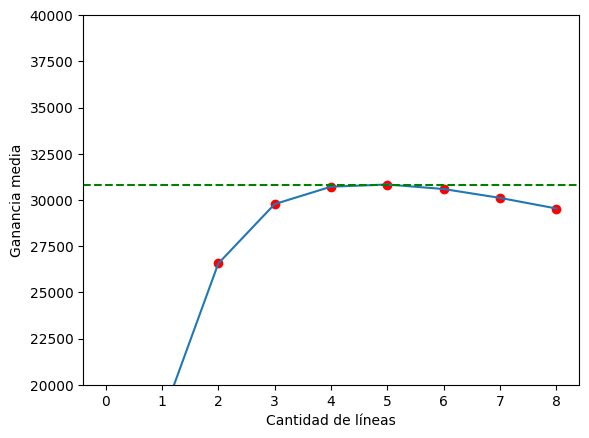

In [60]:

employees_results=[]
for j in range(0,9):
    con = Config(5,20,6,7000,j,[[3,6]],210,50,0.6)
    a=simulate(con)
    for item in a:
        item[1]-=calculate_salaries(j,24,24)
    employees_results.append(a)

datos = [np.mean([item[1] for item in arr])  for arr in employees_results]
plt.ylim(20000,40000)

plt.plot(datos)
plt.scatter(range(len(datos)), datos, color='red')
plt.xlabel('Cantidad de líneas')
plt.ylabel('Ganancia media')

max_valor = max(datos)
max_indice = datos.index(max_valor)
plt.axhline(y=max_valor, color='green', linestyle='--', label=f'Max Value: {max_valor}')


### Media de llamadas no contestadas por día según la cantidad de líneas operando

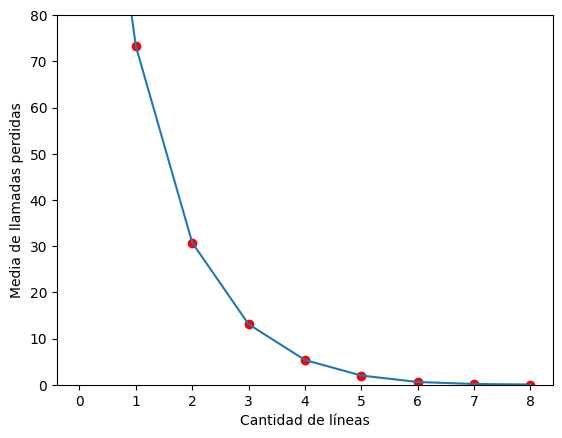

In [61]:
m_call = [np.mean([item[2] for item in arr])  for arr in employees_results]

plt.ylim(0,80)
plt.xlabel('Cantidad de líneas')
plt.ylabel('Media de llamadas perdidas')
plt.plot(m_call)
plt.scatter(range(len(m_call)), m_call, color='red')
#plt.plot_date(datos)


### Prueba de hipótesis para comprobar si la diferencia entre las ganancias con 3 y 5 líneas es significativa

In [62]:
con = Config(5,20,6,7000,3,[[3,6]],210,50,0.6)
a=simulate(con)
analysis_3 = [a[i][1]-calculate_salaries(4,24,24) for i in range(len(a))]

con1 = Config(5,20,6,7000,5,[[3,6]],210,50,0.6)
b=simulate(con1)
analysis_5 = [b[i][1]-calculate_salaries(5,24,24) for i in range(len(b))]

# Rendimiento con 3 trabajadores (simulado)
performance_3_workers = analysis_3

# Rendimiento con 5 trabajadores (simulado)
performance_5_workers = analysis_5

# Realizamos la prueba t de dos muestras independientes
t_stat, p_value = stats.ttest_ind(performance_3_workers, performance_5_workers)

# Resultados
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Decisión basada en el p-value
alpha = 0.05  # Nivel de significancia

if p_value < alpha:
    print("Rechazamos la hipótesis nula: La central obtiene mayor ganancia con 5 trabajadores que con 3.")
else:
    print("No podemos rechazar la hipótesis nula: No hay evidencia suficiente para afirmar que la central obtiene mayor ganancia con 5 trabajadores que con 3.")

T-statistic: -24.416917196495444
P-value: 6.459292513782736e-125
Rechazamos la hipótesis nula: La central obtiene mayor ganancia con 5 trabajadores que con 3.


### Media de ganancias por día según el tiempo medio de atención de una llamada

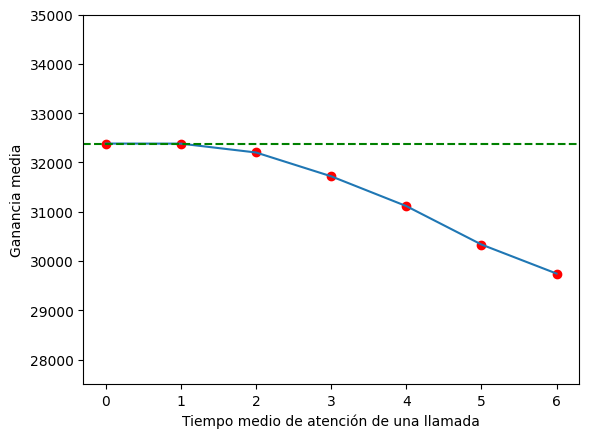

In [63]:
employees_results=[]
for j in range(0,7):
    con = Config(5,20,j,7000,3,[[3,6]],210,50,0.6)
    a=simulate(con)
    for item in a:
        item[1]-=calculate_salaries(3,24,24)
    employees_results.append(a)

datos = [np.mean([item[1] for item in arr])  for arr in employees_results]
plt.ylim(27500,35000)

plt.plot(datos)
plt.scatter(range(len(datos)), datos, color='red')
plt.xlabel('Tiempo medio de atención de una llamada')
plt.ylabel('Ganancia media')

max_valor = max(datos)
max_indice = datos.index(max_valor)
plt.axhline(y=max_valor, color='green', linestyle='--', label=f'Max Value: {max_valor}')

### Prueba de hipótesis para comprobar si la diferencia entre las llamadas no atendidas con 3 y 5 líneas es significativa

In [64]:
con = Config(5,20,6,7000,3,[[3,6]],210,50,0.6)
a=simulate(con)
analysis_3 = [a[i][2]-calculate_salaries(4,24,24) for i in range(len(a))]

con1 = Config(5,20,6,7000,5,[[3,6]],210,50,0.6)
b=simulate(con1)
analysis_5 = [b[i][2]-calculate_salaries(5,24,24) for i in range(len(b))]

# Rendimiento con 3 trabajadores (simulado)
performance_3_workers = analysis_3

# Rendimiento con 5 trabajadores (simulado)
performance_5_workers = analysis_5

# Realizamos la prueba t de dos muestras independientes
t_stat, p_value = stats.ttest_ind(performance_3_workers, performance_5_workers)

# Resultados
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Decisión basada en el p-value
alpha = 0.05  # Nivel de significancia

if p_value < alpha:
    print("Rechazamos la hipótesis nula: La central pierde menor cantidad de llamadas con 5 trabajadores que con 3.")
else:
    print("No podemos rechazar la hipótesis nula: No hay evidencia suficiente para afirmar que la central pierde menor cantidad de llamadas con 5 trabajadores que con 3.")

T-statistic: 5549.820160982584
P-value: 0.0
Rechazamos la hipótesis nula: La central pierde menor cantidad de llamadas con 5 trabajadores que con 3.


### Media de llamadas no atendidas por día según el tiempo medio de atención de una llamada

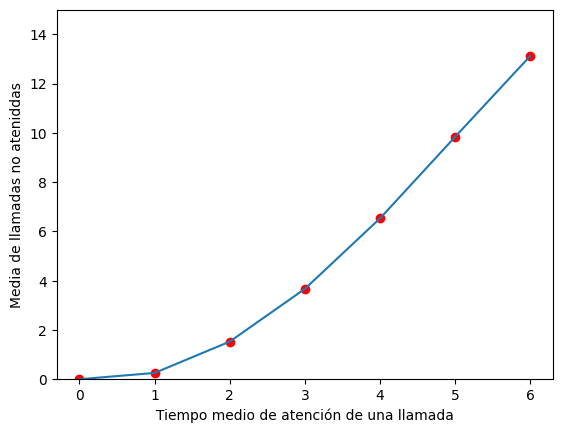

In [65]:
m_call = [np.mean([item[2] for item in arr])  for arr in employees_results]

plt.ylim(0,15)
plt.xlabel('Tiempo medio de atención de una llamada')
plt.ylabel('Media de llamadas no ateniddas')

plt.plot(m_call)
plt.scatter(range(len(m_call)), m_call, color='red')
#plt.plot_date(datos)

### Comparación de ganancias variando el número de líneas operando vs la duracion media de una llamada

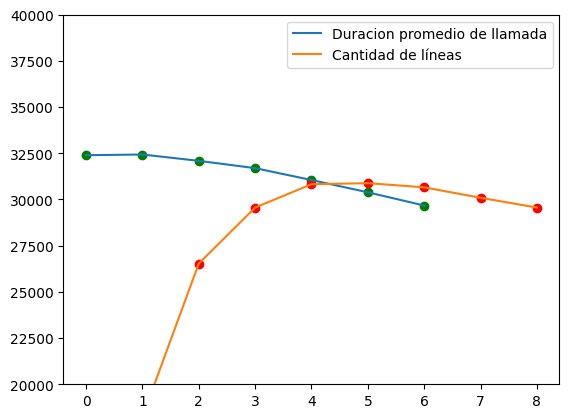

In [66]:
employees_results=[]
for j in range(0,9):
    con = Config(5,20,6,7000,j,[[3,6]],210,50,0.6)
    a=simulate(con)
    for item in a:
        item[1]-=calculate_salaries(j,24,24)
    employees_results.append(a)

datos = [np.mean([item[1] for item in arr])  for arr in employees_results]
plt.ylim(20000,40000)

employees_resultsa=[]
for j in range(0,7):
    con = Config(5,20,j,7000,3,[[3,6]],210,50,0.6)
    a=simulate(con)
    for item in a:
        item[1]-=calculate_salaries(3,24,24)
    employees_resultsa.append(a)

datosll = [np.mean([item[1] for item in arr])  for arr in employees_resultsa]
#plt.ylim(27500,35000)

plt.plot(datosll,label='Duracion promedio de llamada')
plt.scatter(range(len(datosll)), datosll, color='green')


plt.plot(datos,label='Cantidad de líneas')

plt.legend()
plt.scatter(range(len(datos)), datos, color='red')

### Comparación de llamadas no atendidas variando el número de líneas operando vs la duracion media de una llamada

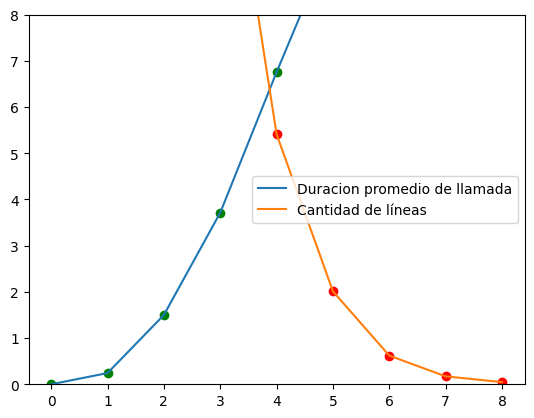

In [22]:
m_call = [np.mean([item[2] for item in arr])  for arr in employees_results]
n_call = [np.mean([item[2] for item in arr])  for arr in employees_resultsa]

plt.ylim(0,8)
plt.plot(n_call,label='Duracion promedio de llamada')
plt.plot(m_call,label='Cantidad de líneas')
plt.legend()
plt.scatter(range(len(m_call)), m_call, color='red')
plt.scatter(range(len(n_call)), n_call, color='green')

### Prueba de hipótesis para comprobar si la diferencia entre las llamadas no atendidas con 5 líneas es significativa con respecto a las llamadas perdidas con una media de atención de 4 minutos

In [26]:
missed_calls_lines=[item[2] for item in employees_results[5]]
missed_calls_attention=[item[2] for item in employees_resultsa[4]]

# Realizamos la prueba t de dos muestras independientes
t_stat_1, p_value_1 = stats.ttest_ind(missed_calls_attention, missed_calls_lines)

# Resultados
print(f"T-statistic: {t_stat_1}")
print(f"P-value: {p_value_1}")

# Decisión basada en el p-value
alpha_1 = 0.05  # Nivel de significancia

if p_value_1 < alpha_1:
    print("Rechazamos la hipótesis nula: La diferencia de llamadas perdidas con 5 líneas telefónicas es significativa con respecto a las llamadas con media de atención de 4 minutos.")
else:
    print("No podemos rechazar la hipótesis nula: No hay evidencia suficiente para afirmar que la diferencia de llamadas perdidas con 5 líneas telefónicas es significativa con respecto a las llamadas con media de atención de 4 minutos.")




T-statistic: 60.58194238805908
P-value: 0.0
Rechazamos la hipótesis nula: La diferencia de llamadas perdidas con 5 líneas telefónicas es significativa con respecto a las llamadas con media de atención de 4 minutos.


In [55]:
z=simulate(Config(5,20,6,7000,3,[[3,6]],210,50,0.6))
len(z)

2499